In [4]:
from google.colab import files
import json

# 1. Upload and grab whatever filename Colab gives you
uploaded = files.upload()
# e.g. uploaded.keys() -> dict_keys(['user-wallet-transactions.json'])
fname = list(uploaded.keys())[0]

# 2. Load the JSON from that filename
with open(fname, 'r') as f:
    raw = json.load(f)     # raw is a list of tx dicts
print(f"Loaded {len(raw)} transactions from {fname}")


# 2. Flatten into a DataFrame
import pandas as pd

rows = []
for rec in raw:
    # parse amount + price
    amt_raw = int(rec['actionData']['amount'])
    price_usd = float(rec['actionData'].get('assetPriceUSD', 0))
    # If you know token decimals, you can scale amt_raw → token_amt here.
    usd_value = amt_raw * price_usd

    rows.append({
      'wallet':        rec['userWallet'],
      'action':        rec['action'],
      'timestamp':     rec['timestamp'],
      'raw_amount':    amt_raw,
      'usd_amount':    usd_value
    })

tx_df = pd.DataFrame(rows)

# 3. Group by wallet & extract features
feature_list = []
for wallet, g in tx_df.groupby('wallet'):
    counts = g['action'].value_counts().to_dict()

    t0, t1 = g['timestamp'].min(), g['timestamp'].max()
    active_days = (t1 - t0) / (3600 * 24)

    deposits    = g[g['action']=='deposit']
    borrows     = g[g['action']=='borrow']
    repays      = g[g['action']=='repay']
    liquidates  = g[g['action']=='liquidationcall']

    feature_list.append({
      'wallet':            wallet,
      'total_tx':          len(g),
      'deposit_count':     counts.get('deposit', 0),
      'borrow_count':      counts.get('borrow', 0),
      'repay_count':       counts.get('repay', 0),
      'liquidation_count': counts.get('liquidationcall', 0),
      'borrow_to_deposit': len(borrows) / (len(deposits) + 1),
      'repay_to_borrow':   len(repays)  / (len(borrows) + 1),
      'active_days':       active_days,
      'avg_usd_deposit':   deposits['usd_amount'].mean() if len(deposits) else 0,
      'avg_usd_borrow':    borrows['usd_amount'].mean()  if len(borrows)  else 0
    })

features_df = pd.DataFrame(feature_list)

# 4. Inspect
features_df.head(10)


Saving user-wallet-transactions.json to user-wallet-transactions (1).json
Loaded 100000 transactions from user-wallet-transactions (1).json


,wallet,total_tx,deposit_count,borrow_count,repay_count,liquidation_count,borrow_to_deposit,repay_to_borrow,active_days,avg_usd_deposit,avg_usd_borrow
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,1,0,0,0,0.000000,0.000000,0.000000,1.987664e+09,0.000000e+00
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,1,0,0,0,0.000000,0.000000,0.000000,2.856945e+20,0.000000e+00
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,2,0,0,0,0.000000,0.000000,7.574132,2.576155e+15,0.000000e+00
3,0x0000000000e189dd664b9ab08a33c4839953852c,17,0,0,0,0,0.000000,0.000000,129.327766,0.000000e+00,0.000000e+00
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,399,250,15,4,0,0.059761,0.250000,132.865903,8.263093e+20,4.019841e+21
5,0x000000000a38444e0a6e37d3b630d7e855a7cb13,25,7,8,5,0,1.000000,0.555556,39.280174,2.627238e+21,1.453929e+09
6,0x000000003853fcedcd0355fec98ca3192833f00b,8,8,0,0,0,0.000000,0.000000,7.889201,9.547039e+15,0.000000e+00
7,0x000000003ce0cf2c037493b1dc087204bd7f713e,492,309,30,16,0,0.096774,0.516129,123.501505,1.484098e+21,4.413859e+21
8,0x000000007858e6f2668e1e06111cfa24403a5466,1,1,0,0,0,0.000000,0.000000,0.000000,1.421607e+17,0.000000e+00
9,0x00000001a0f57e850c9db68b4a9bc34677437c5c,1,1,0,0,0,0.000000,0.000000,0.000000,1.766653e+06,0.000000e+00


In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble     import IsolationForest
import numpy as np
from google.colab import files

# 1️⃣ Pick & scale the numeric feature columns
USE = [
  'total_tx','deposit_count','borrow_count','repay_count',
  'liquidation_count','borrow_to_deposit','repay_to_borrow',
  'active_days','avg_usd_deposit','avg_usd_borrow'
]

scaler = MinMaxScaler()
scaled_vals = scaler.fit_transform(features_df[USE])
scaled_df   = pd.DataFrame(scaled_vals, columns=USE)

# 2️⃣ Rule-based scoring function
def rule_score(r):
    s = 500
    s += 100 * r['repay_to_borrow']                            # reward repayments
    s +=  80 * (r['deposit_count'] / (r['total_tx'] + 1))      # reward deposit share
    s +=  60 * np.log1p(r['active_days'])                      # reward longevity
    s -= 200 * r['liquidation_count']                          # penalize liquidations
    s -= 100 * r['borrow_to_deposit']                          # penalize over‑borrowing
    return np.clip(s, 0, 1000)

scaled_df['rule_score'] = scaled_df.apply(rule_score, axis=1)

# 3️⃣ Anomaly detection & penalty
iso           = IsolationForest(contamination=0.05, random_state=42)
anomaly_flags = iso.fit_predict(scaled_df[USE])
scaled_df['penalty'] = np.where(anomaly_flags == -1, -200, 0)

# 4️⃣ Final hybrid score & attach to wallet list
scaled_df['score'] = (scaled_df['rule_score'] + scaled_df['penalty']).clip(0,1000).astype(int)
output = features_df[['wallet']].copy()
output['score'] = scaled_df['score']

# 5️⃣ Export and download CSV
output.to_csv('wallet_scores.csv', index=False)
files.download('wallet_scores.csv')
print("✅ Done! Downloading wallet_scores.csv with your 0–1000 scores.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Done! Downloading wallet_scores.csv with your 0–1000 scores.


In [6]:
from google.colab import files

# 1) Make sure you’ve already run the hybrid‐scoring cell
#    and have `features_df` and `scaled_df['score']` in your notebook.

# 2) Build the “full” DataFrame:
full_df = features_df.copy()

# Append the `score` column computed by the hybrid model:
full_df['score'] = scaled_df['score']

# 3) Reorder columns (optional):
cols = [
    'wallet',
    'score',
    'total_tx',
    'deposit_count',
    'borrow_count',
    'repay_count',
    'liquidation_count',
    'borrow_to_deposit',
    'repay_to_borrow',
    'active_days',
    'avg_usd_deposit',
    'avg_usd_borrow'
]
full_df = full_df[cols]

# 4) Export & download:
full_df.to_csv('wallet_features_with_score.csv', index=False)
files.download('wallet_features_with_score.csv')
print("✅ Downloading wallet_features_with_score.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloading wallet_features_with_score.csv


In [7]:
# total tx
print("Total transactions:", len(tx_df))

# unique wallets
n_wallets = tx_df['wallet'].nunique()
print("Unique wallets:", n_wallets)

# should match features_df rows
print("Rows in features_df:", len(features_df))


Total transactions: 100000
Unique wallets: 3497
Rows in features_df: 3497


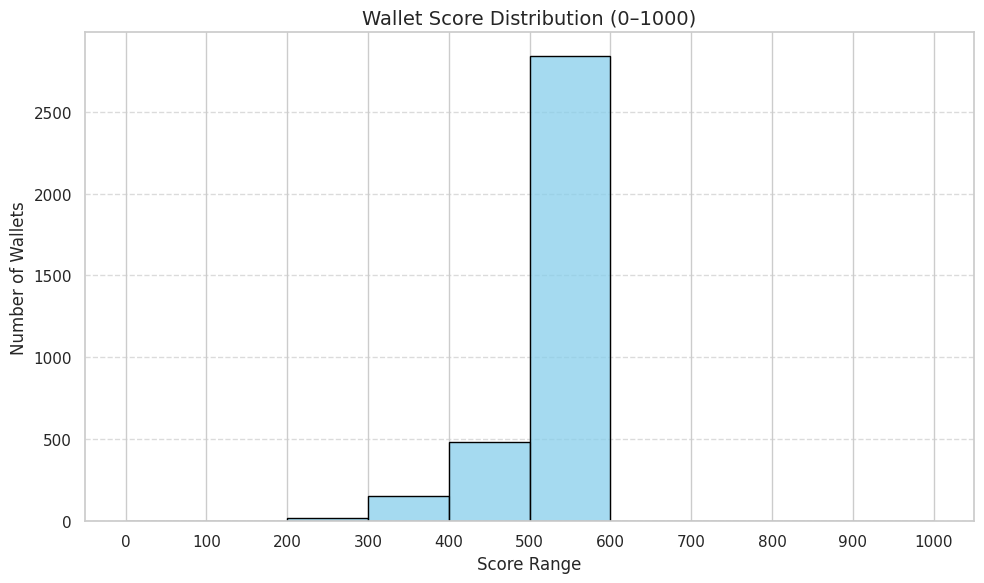

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure score column exists
assert 'score' in full_df.columns, "Score column not found in full_df"

# Define bins
bins = list(range(0, 1100, 100))

# Set plot style
sns.set(style="whitegrid")

# Create figure
plt.figure(figsize=(10, 6))
sns.histplot(full_df['score'], bins=bins, kde=False, color='skyblue', edgecolor='black')

# Title and labels
plt.title('Wallet Score Distribution (0–1000)', fontsize=14)
plt.xlabel('Score Range', fontsize=12)
plt.ylabel('Number of Wallets', fontsize=12)
plt.xticks(bins)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Save as PNG
plt.tight_layout()
plt.savefig("wallet_score_distribution.png", dpi=300)
plt.show()
